In [1]:
!pip install tensorflow==2.10.0

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Flatten, Input, Dense, Dropout
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
!pip install transformers
from transformers import BertTokenizer, TFBertModel
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.9 MB/s eta 0:00:00


In [3]:
#load dataset
df = pd.read_csv("Final_preprocessed_dataset_portuguese.csv")
#df.fillna('', inplace=True)

In [4]:
def plot_train_val_loss_acc(history):
    # plot learning curves
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # plot validation curves
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [5]:
# Tokenize and pad the text data using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, max_length=128, padding='max_length', truncation=True)
    return tokens

df['text_tokens'] = df['text_preprocessed'].apply(tokenize_text)

# Combine all features into one array
x_word_count = df['count_words_text'].values.reshape(-1, 1)
x_nouns_count = df['num_nouns_text'].values.reshape(-1, 1)
x_verbs_count = df['num_verbs_text'].values.reshape(-1, 1)
x_adj_count = df['num_adj_text'].values.reshape(-1, 1)
x_adv_count = df['num_adv_text'].values.reshape(-1, 1)
x_sentiment_avg = df['sentiment_avg_text'].values.reshape(-1, 1)

In [6]:
from sklearn.preprocessing import StandardScaler
x_combined = np.concatenate([np.vstack(df['text_tokens']), x_word_count, x_nouns_count, x_verbs_count, x_adj_count, x_adv_count, x_sentiment_avg], axis=1)

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_combined, df['Label'], test_size=0.2, random_state=42)

# Standardize the input features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [7]:
from keras.layers import Concatenate
from tensorflow.keras.optimizers import Adam

# Build the model
input_ids = Input(shape=(134,), dtype=tf.int32, name='input_ids')
features_input = Input(shape=(x_train_scaled.shape[1],), dtype=tf.float32, name='features_input')

# Load the pre-trained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

# Freeze the pre-trained layers
for layer in bert_model.layers:
    layer.trainable = True

# Pass the input through the pre-trained BERT model
sequence_output = bert_model(input_ids)[0]

# Flatten the sequence output tensor
sequence_output_flattened = Flatten()(sequence_output)

# Add a Dropout layer
dropout_rate = 0.2  # You can adjust the dropout rate as needed
dropout_output = Dropout(rate=dropout_rate)(sequence_output_flattened)

# Concatenate the flattened sequence output with the additional features input
concatenated = Concatenate()([dropout_output, features_input])

# Define the output layer and the full model
output_layer = Dense(1, activation='sigmoid')(concatenated)
model = Model(inputs=[input_ids, features_input], outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [8]:
history = model.fit(
    [x_train, x_train_scaled],  # Use the entire x_train here
    y_train,
    validation_data=([x_test, x_test_scaled], y_test),  # Use the entire x_test here
    epochs=10,
    batch_size=64,
    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=1, verbose=False, restore_best_weights=True)]
)

Epoch 1/10


791/791 [==============================] - 1612s 2s/step - loss: 0.2479 - accuracy: 0.8898 - val_loss: 0.1624 - val_accuracy: 0.9258
Epoch 2/10
791/791 [==============================] - 1603s 2s/step - loss: 0.1323 - accuracy: 0.9431 - val_loss: 0.1559 - val_accuracy: 0.9353
Epoch 3/10
791/791 [==============================] - 1605s 2s/step - loss: 0.0787 - accuracy: 0.9674 - val_loss: 0.1504 - val_accuracy: 0.9371
Epoch 4/10
791/791 [==============================] - 1605s 2s/step - loss: 0.0466 - accuracy: 0.9826 - val_loss: 0.1574 - val_accuracy: 0.9399
Epoch 5/10
791/791 [==============================] - 1604s 2s/step - loss: 0.0266 - accuracy: 0.9917 - val_loss: 0.1931 - val_accuracy: 0.9364
Epoch 6/10
791/791 [==============================] - 1604s 2s/step - loss: 0.0200 - accuracy: 0.9942 - val_loss: 0.1976 - val_accuracy: 0.9365
Epoch 7/10
791/791 [==============================] - 1602s 2s/step - loss: 0.0155 - accuracy: 0.9954 - val_loss: 0.2088 - val_accuracy: 0.9394


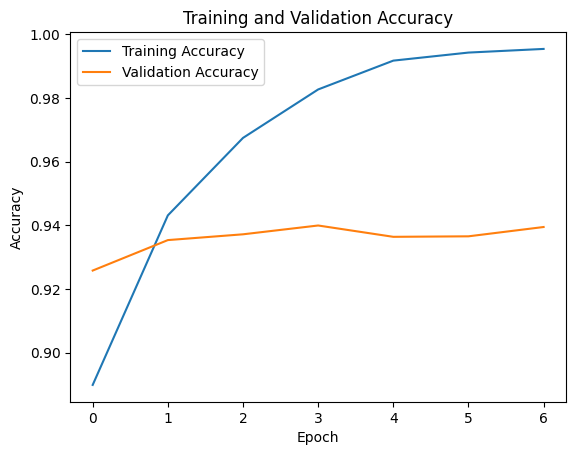

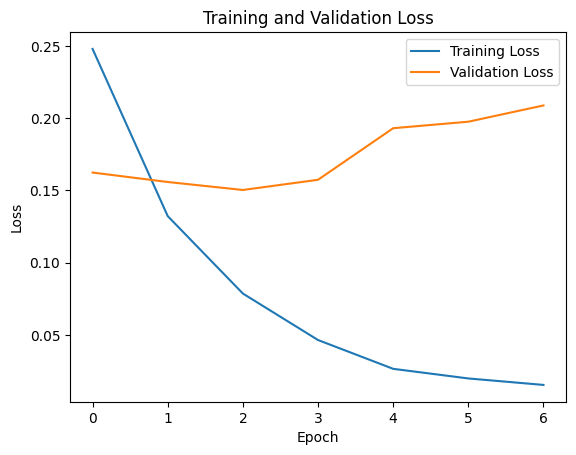

In [9]:
plot_train_val_loss_acc(history)

In [10]:
# Evaluate the model
loss, accuracy = model.evaluate([x_test, x_test_scaled], y_test, batch_size=64)
print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}")

198/198 [==============================] - 119s 603ms/step - loss: 0.1574 - accuracy: 0.9399
Test loss: 0.157, Test accuracy: 0.940


396/396 [==============================] - 120s 296ms/step
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      6285
           1       0.93      0.95      0.94      6363

    accuracy                           0.94     12648
   macro avg       0.94      0.94      0.94     12648
weighted avg       0.94      0.94      0.94     12648



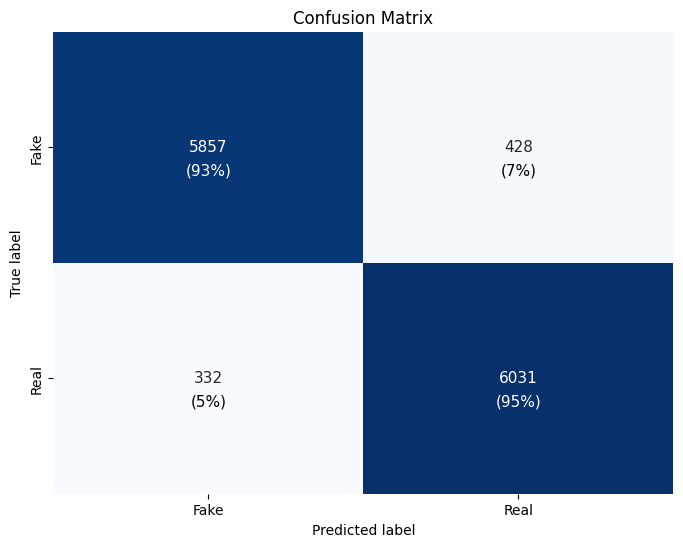

In [11]:
# Classification Report and Confusion Matrix
y_pred_test = model.predict([x_test, x_test_scaled])

print(classification_report(y_test, np.where(y_pred_test >= 0.5, 1, 0)))

# Compute confusion matrix
conf_mat = confusion_matrix(y_test, np.where(y_pred_test >= 0.5, 1, 0))

# Compute normalized values
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                 xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'], annot_kws={"fontsize": 11})

# Add normalized values below the actual values
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        text_color = 'black' if conf_mat_norm[i, j] < 0.5 else 'white'
        ax.text(j + 0.5, i + 0.6, f'({conf_mat_norm[i, j]:.0%})', ha='center', va='center', color=text_color, fontsize=11)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()